In [1]:
import numpy as np
import tensorflow as tf

# Instead of using Keras API to feed image into the model,
# we need our own Variable tensor so we can use it directly.
input_tn = tf.Variable(np.empty([1, 224, 224, 3]), dtype='float32')

# Note that we load the model without any fully connected layers,
# since we will not use this model as a classifier in this notebook.
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(input_tensor=input_tn, include_top=False, input_shape=(224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from utils import plot_image, load_tiny_batch, plot_images_grid, crop_and_resize_for_imagenet

# Loads a tiny batch of images from Internet
images_raw = load_tiny_batch()

# Cropped and/or resized into ImageNet shape 224x244x3 array of type uint8 [0, 255]
images_resized = {name: crop_and_resize_for_imagenet(image) for name, image in images_raw.items()}

plot_images_grid(images_resized)

In [3]:
# Note that we need to get Tenserflow session from Keras,
# because it's the only session where VGG16 is initialized
# with the pre-trained weights. New sessions have random initialization.
s = tf.keras.backend.get_session()

In [4]:
# Confirm the model has all required layers.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 224, 224, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (1, 224, 224, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (1, 224, 224, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (1, 112, 112, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (1, 112, 112, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (1, 112, 112, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (1, 56, 56, 128)          0         
__________

In [5]:
# In order to visualize the first layer's kernels directly,
# we can look at the list weights and choose the first convolution.
# There are two ways to find the right variable:
# 1. By looking at its name. Larger numbers typically correspond to deeper layers.
# 2. By looking at its input channels. The first layer has 3 input channels.
variables = {w.name:w for w in model.weights}
variables

{'block1_conv1/kernel:0': <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>,
 'block1_conv1/bias:0': <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>,
 'block1_conv2/kernel:0': <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>,
 'block1_conv2/bias:0': <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32>,
 'block2_conv1/kernel:0': <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32>,
 'block2_conv1/bias:0': <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32>,
 'block2_conv2/kernel:0': <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32>,
 'block2_conv2/bias:0': <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32>,
 'block3_conv1/kernel:0': <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32>,
 'block3_conv1/bias:0': <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32>,
 'block3_conv2/kernel:0': <tf.Variable 'block3_conv2/kerne

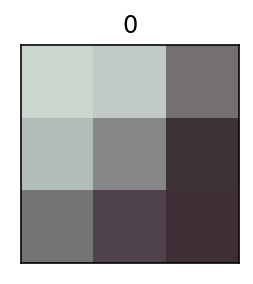

In [6]:
import numpy as pn
from utils import plot_conv_kernel
    
# First, we need to extract the variable's current state
# from Tensorflow graph. Note that we need to use the same
# session as created by Keras, because it's the only session
# where the model's variables are initialized to pre-trained values.
kernel = s.run(variables['block1_conv1/kernel:0'])

# plot_conv_kernel is a helper function that plots kernels as images.
# See utils.py for details.
plot_conv_kernel(kernel[:, :, :, 0])

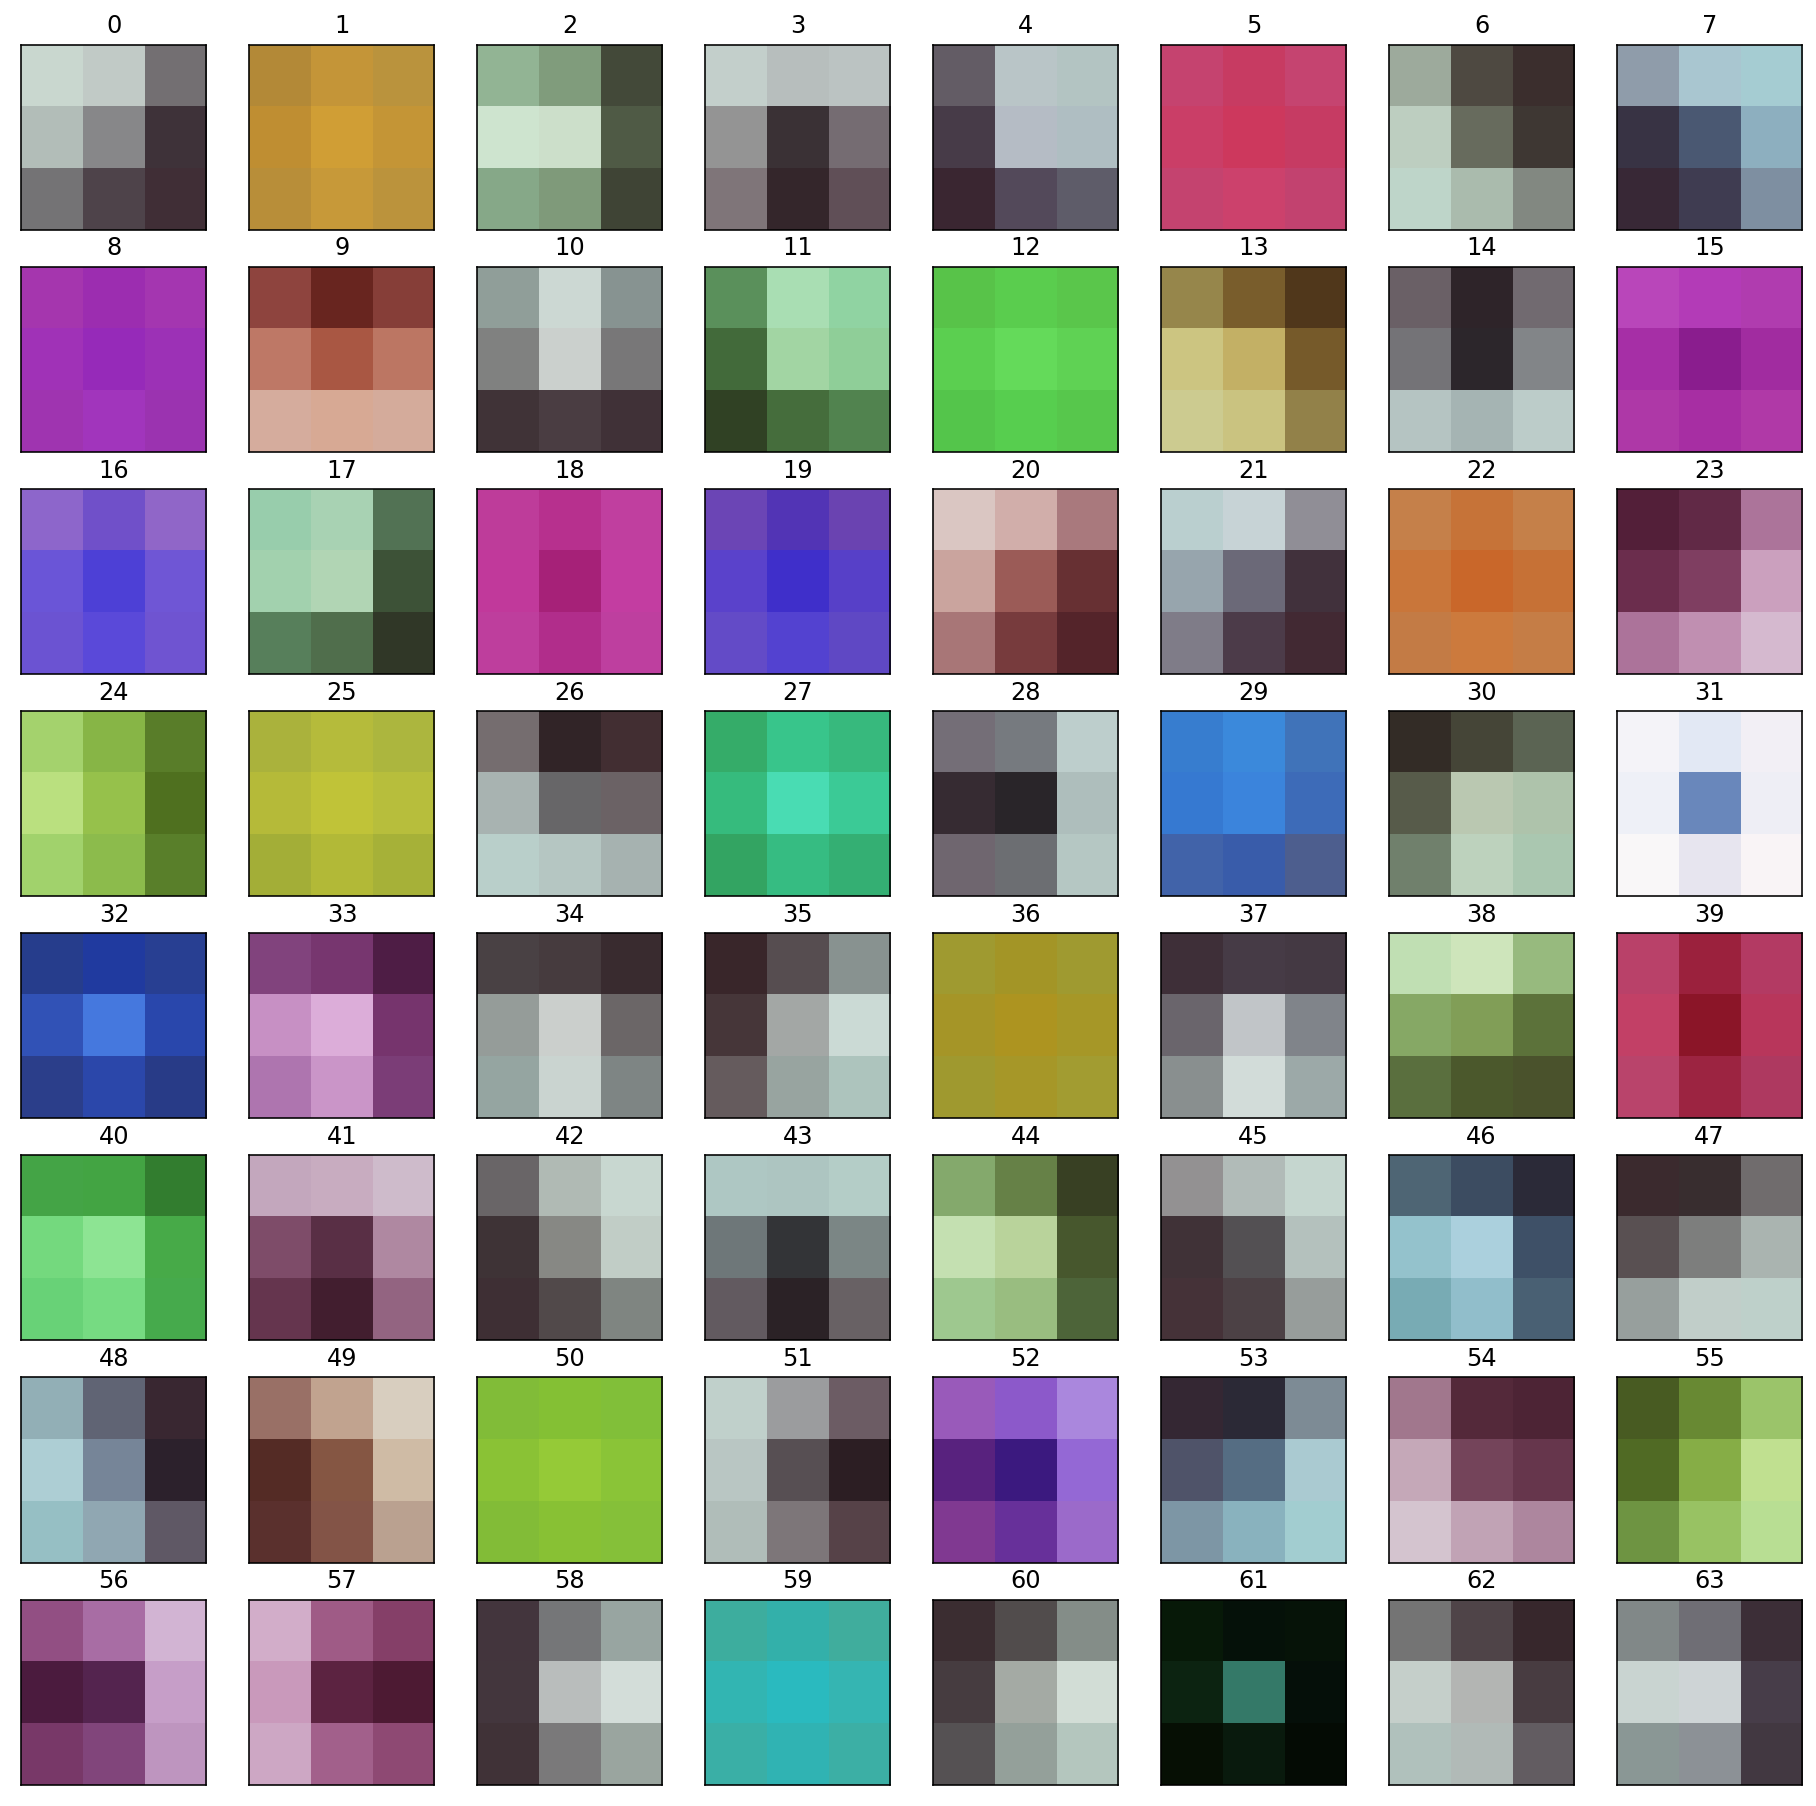

In [7]:
# We can also plot all output channels at once.
plot_conv_kernel(kernel)

In [8]:
# Now let's visualize a deep convolutional layer.
# For this we will need to:
# 1. Choose a convolutional layer,
# 2. Feed an image through the network,
# 3. Plot a convolutional layer's activation volume.

# List all convolutional operations in a graph,
# so that we can plot one of them.
[op for op in s.graph.get_operations() if op.type == 'Conv2D']

[<tf.Operation 'block1_conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'block1_conv2/Conv2D' type=Conv2D>,
 <tf.Operation 'block2_conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'block2_conv2/Conv2D' type=Conv2D>,
 <tf.Operation 'block3_conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'block3_conv2/Conv2D' type=Conv2D>,
 <tf.Operation 'block3_conv3/Conv2D' type=Conv2D>,
 <tf.Operation 'block4_conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'block4_conv2/Conv2D' type=Conv2D>,
 <tf.Operation 'block4_conv3/Conv2D' type=Conv2D>,
 <tf.Operation 'block5_conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'block5_conv2/Conv2D' type=Conv2D>,
 <tf.Operation 'block5_conv3/Conv2D' type=Conv2D>]

In [9]:
# If you need extra help finding the right operation,
# you can save the graph and view it in Tensorboard.
# This creates a new folder and saves the current
# Tensorflow graph in it for visualization in Tensorboard.
tf.summary.FileWriter(
    'tf_logs',
    graph=s.graph,
    session=s
).close()

# See docs: https://www.tensorflow.org/tensorboard/graphs

In [10]:
# Each Tensorflow operation has zero or more tensors that
# correspond to that operation's output. In the case
# of Conv2D operation, the 0th output is the activation volume.
# By Tensorflow convention, the name of an operation's output
# is the name of the operation with :0, :1, :2, ..., :n suffix.
# For example, if operation name is conv42, then the name of the tensor 
# that holds its activation volume is conv42:0
conv_tn = s.graph.get_tensor_by_name('block5_conv1/Conv2D:0')

# Additionally here are examples of extracting output tensors
# of a ReLU and MaxPooling operations.
relu_tn = s.graph.get_tensor_by_name('block5_conv1/Relu:0')
max_tn = s.graph.get_tensor_by_name('block5_pool/MaxPool:0')

# Each tensor's shape is (batch size, height, width, depth).
# Since we only want to look at one image, we can drop the batch dimension.
activation_volume_tn = max_tn[0]
activation_volume_tn.shape

TensorShape([Dimension(7), Dimension(7), Dimension(512)])

(1, 224, 224, 3)

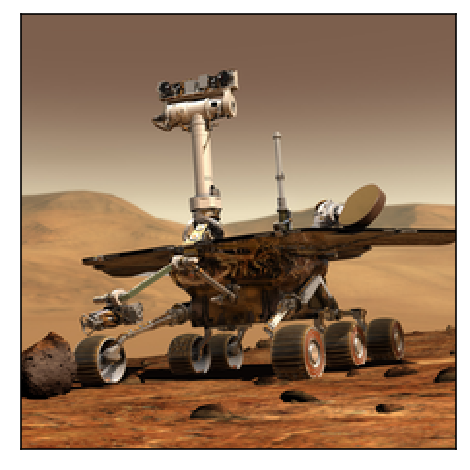

In [11]:
# We will feed this image through the network.
image_start = images_resized['rover']

# The model expects a batch of images, so we need
# to create one more dimension, even though we only 
# have one image the batch.
image_start = np.expand_dims(images_resized['rover'], 0)

plot_image(image_start[0])

image_start.shape

In [12]:
# In order to feed the network with an image,
# the image has to be assigned to the input variable
# that was passed into VGG16() constructor call.
s.run(input_tn.assign(image_start))

# Evaluate the activation volume tensor.
activation_volume = s.run(activation_volume_tn)

# Confirm the shape of the activation volume.
activation_volume.shape

(7, 7, 512)

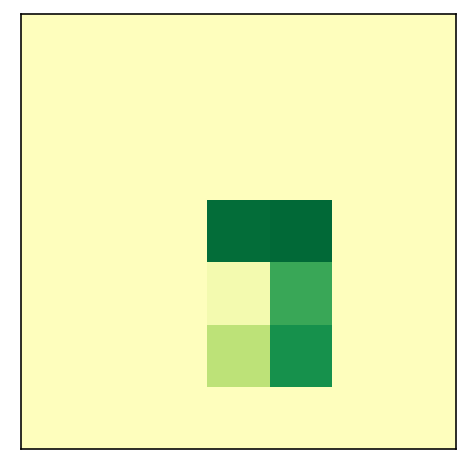

In [13]:
from utils import plot_activation_map

# plot_activation_map is a helper function that
# rescales the map to have std = 1, and applies sigmoid.
# See utils.py for details.
plot_activation_map(activation_volume[:, :, 0])

In [14]:
from utils import plot_activation_volume

# plot_activation_volume is a helper function that
# creates a grid of activation maps from 3-dimensional array.
# Note that it might not plot every channel, because
# the size of the grid is controlled by side parameter,
# and not by the activation volume's depth.
# See utils.py for details.
plot_activation_volume(activation_volume, side=16)

In [15]:
# Another method to visualize a deep convolutional layer is
# to search for an image that maximizes its activation.

# Here are the necessary steps:
# 1. Select an activation map
# 2. Calculate its avarage across the spatial dimensions
# 3. Calculate the gradients of the average activation with respect to the input image
# 4. Make a step towards the higher activation
# 5. Clip the image to be within [0, 255] range.
# 6. Repeat steps 2-5 for X iterations

channel = 0
activation_map_tn = activation_volume_tn[:, :, channel]

# Note that the cost is the negative of the average, 
# since we want to maximize the average activation,
# while decreasing the cost.
cost_tn = -tf.reduce_mean(activation_map_tn) #+ 0.001 * tf.norm(input_tn)
gradient_tn = tf.gradients(cost_tn, input_tn)[0]

# Due to the range of pixel values, it seems that
# the learning rate needs to be between 1e3 and 1e5.
learning_rate = 10000

new_image_tn = input_tn - learning_rate * gradient_tn
new_image_tn = tf.clip_by_value(new_image_tn, 0, 255)

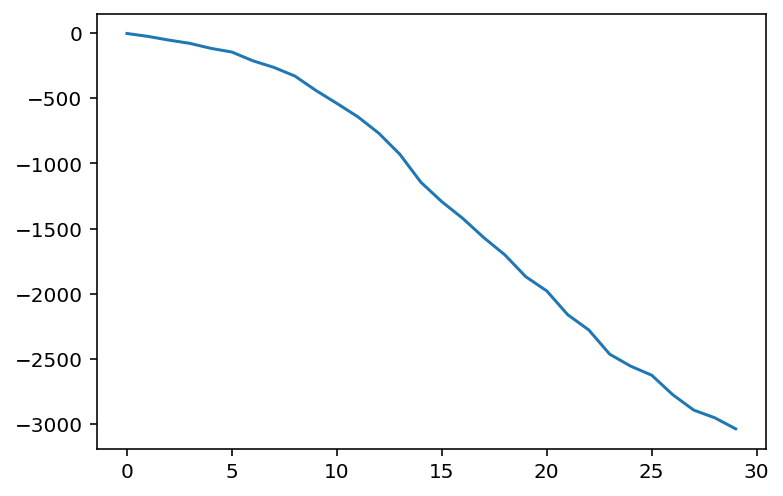

In [16]:
import seaborn as sns

# Finally, let's run the learning process for 
# X iterations, while collecting the following
# values at each iteration step:
# 1. gradient
# 2. cost value
# 3. activation map
# 4. current image
iterations = 30
gradients = []
learning_curve = []
activations = []
images = []

image_current = image_start

for i in range(iterations):
    # Save the current image
    images.append(image_current[0].astype(int))
    
    # Assign the current image to the input variable
    s.run(input_tn.assign(image_current))
    
    # Evaluate all the tensors
    image_new, activation, cost, grad = s.run([
        new_image_tn, 
        activation_map_tn, 
        cost_tn, 
        gradient_tn
    ])
    
    # Save the values for analysis
    gradients.append(grad)
    learning_curve.append(cost)
    activations.append(activation)
    
    # Update the current image for
    # next iteration step.
    image_current = image_new
    
# Once the learning is finished, plot the learning curve.
sns.lineplot(range(len(learning_curve)), learning_curve)

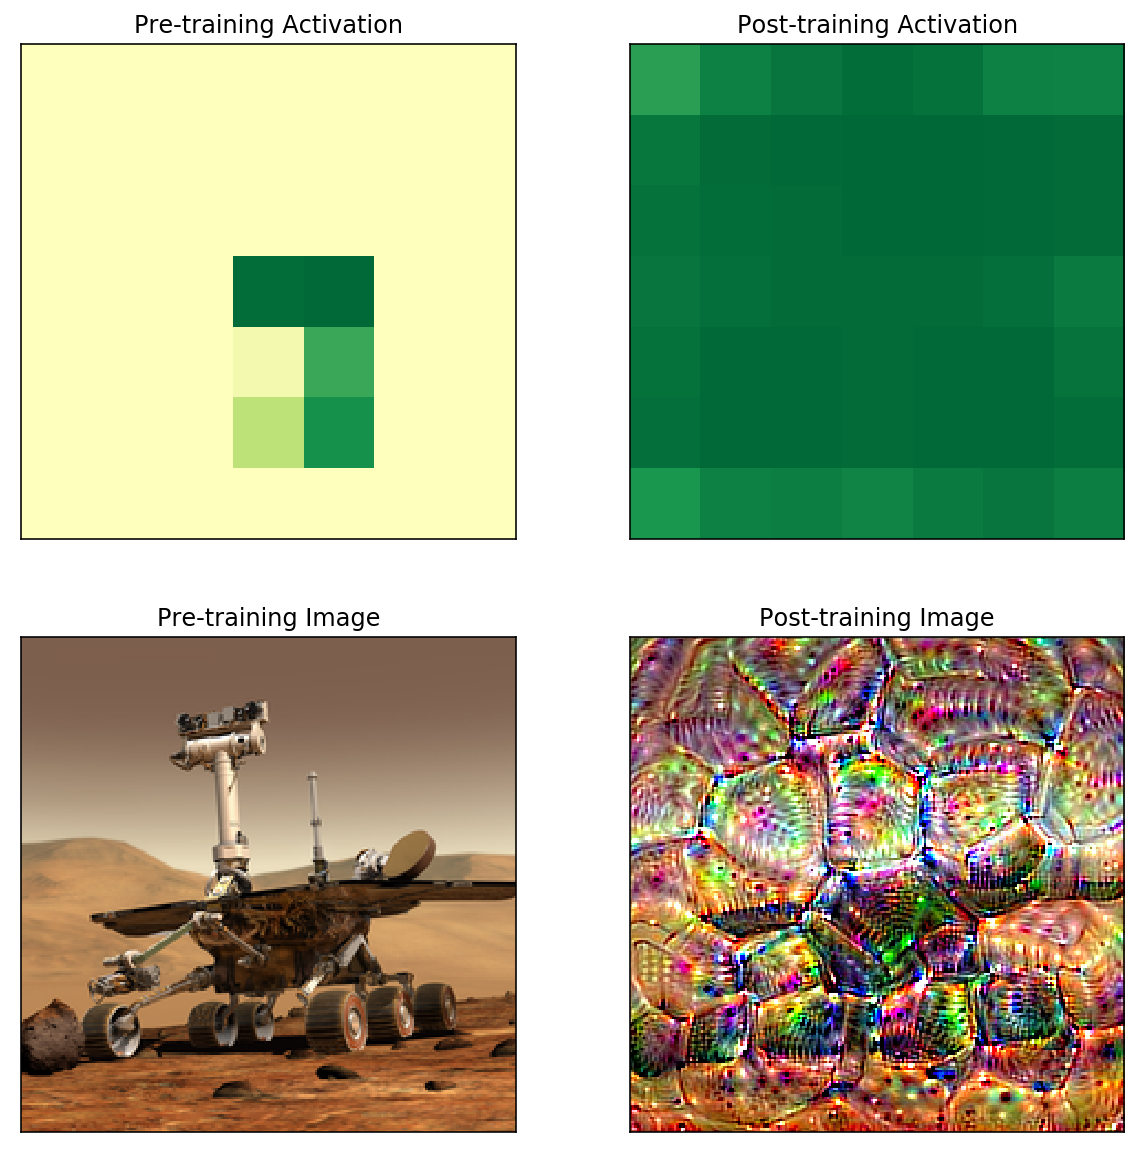

In [17]:
from utils import plot_activation_map

plt.figure(figsize=[10, 10])

plt.subplot(2, 2, 1)
plt.title('Pre-training Activation')
plot_activation_map(activations[0])

plt.subplot(2, 2, 2)
plt.title('Post-training Activation')
plot_activation_map(activations[-1])

plt.subplot(2, 2, 3)
plt.title('Pre-training Image')
plot_image(images[0])

plt.subplot(2, 2, 4)
plt.title('Post-training Image')
plot_image(images[-1])

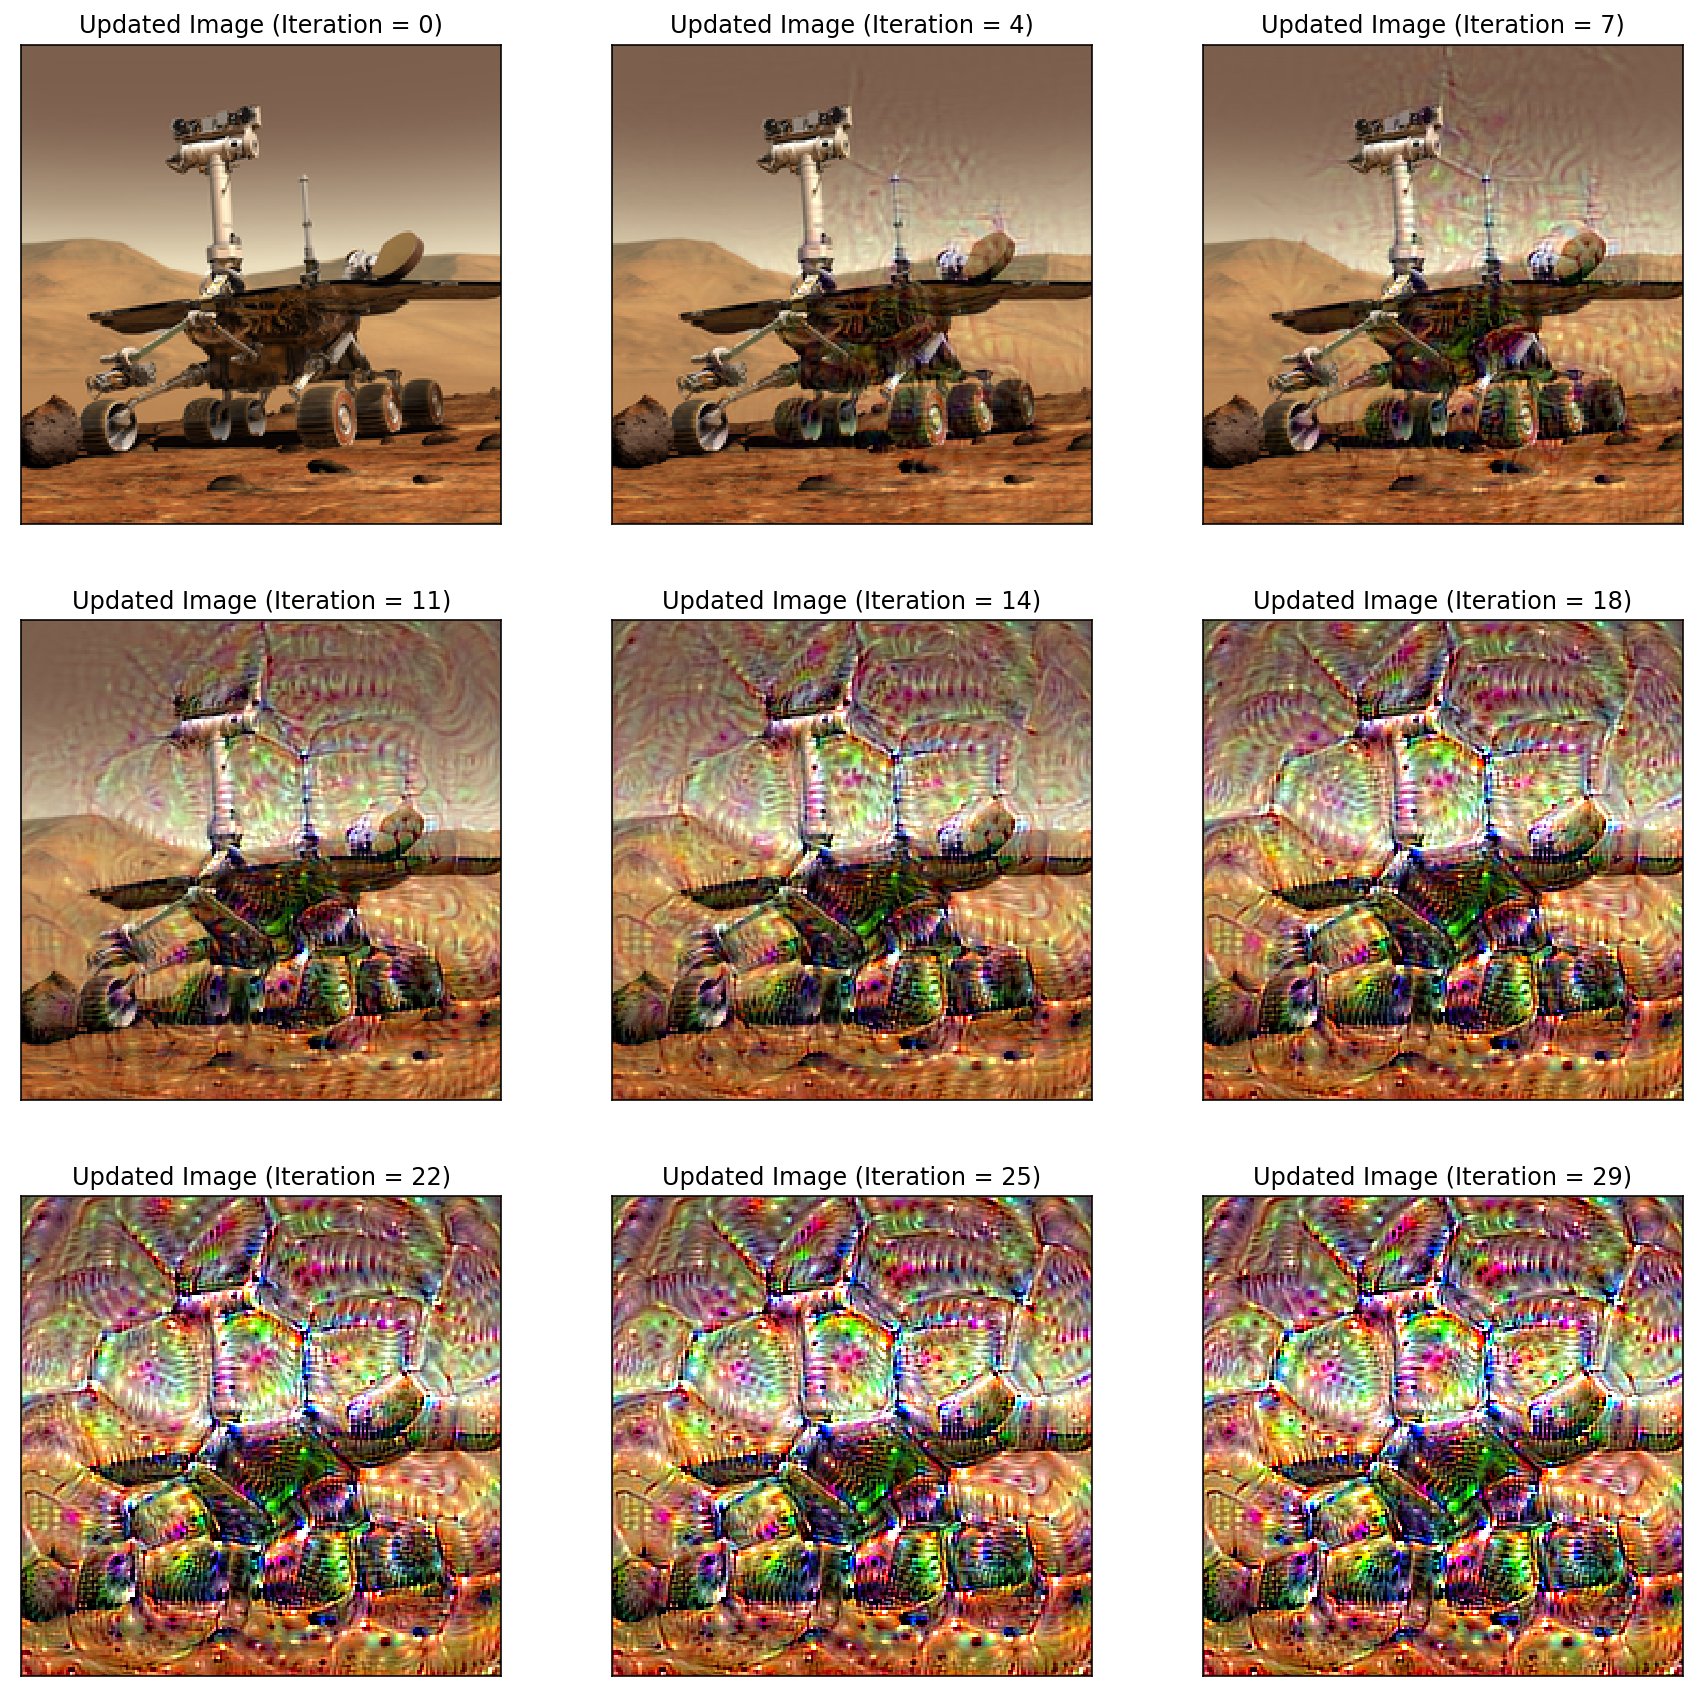

In [18]:
nrows = 3
ncols = 3
plt.figure(figsize=[5 * ncols, 5 * nrows])
idxs = np.linspace(0, len(images)-1, nrows*ncols)
idxs = idxs.round().astype(int)

for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plot_image(images[idx])
    plt.title(f'Updated Image (Iteration = {idx})')

In [20]:
# This code cells saves the updated image
# after each iteration to a local folder.
# Use gif.sh script to animate the images.

from PIL import Image
import os

previous_dreams = [
    int(n.split('dream')[1]) for n in os.listdir('.') 
    if n.startswith('dream')
]

if len(previous_dreams) > 0:
    next_dream = max(previous_dreams) + 1
else:
    next_dream = 0

folder = f'dream{next_dream}'
os.system(f'mkdir -p {folder}')
for idx, image in enumerate(images):
    Image.fromarray(image.astype('uint8')).save(f'{folder}/{idx}.png')
    
print(f'Images are saved to {folder}')

Images are saved to dream0


In [21]:
%%html
<img src="./vgg_dream_rover.gif">

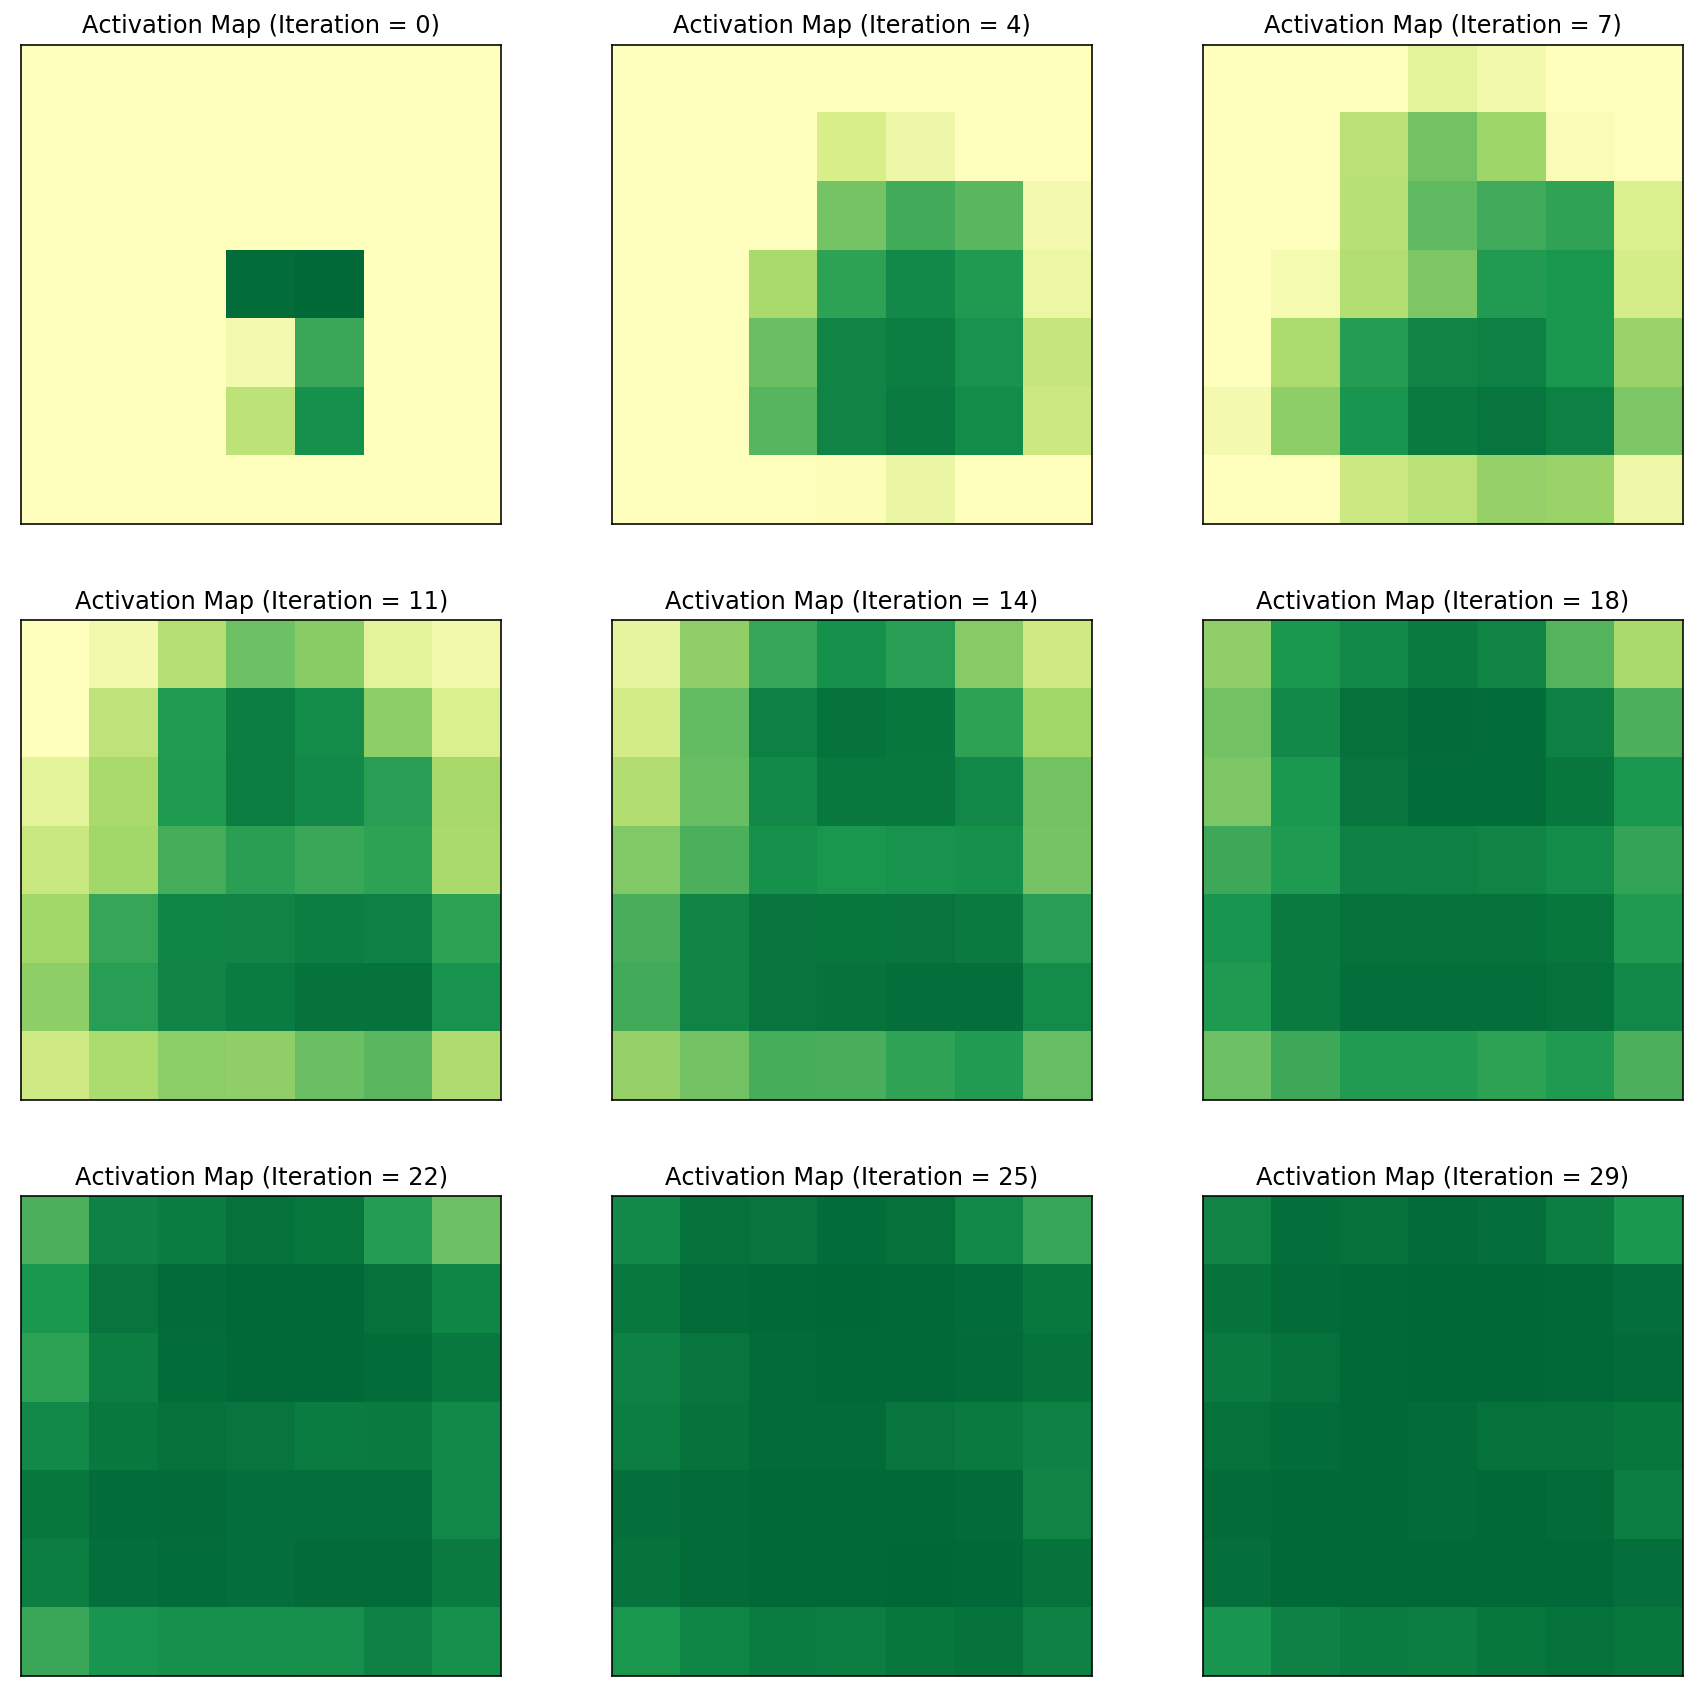

In [19]:
nrows = 3
ncols = 3
idxs = np.linspace(0, len(activations)-1, nrows*ncols)
idxs = idxs.round().astype(int)

plt.figure(figsize=[5 * ncols, 5 * nrows])

for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plot_activation_map(activations[idx])
    plt.title(f'Activation Map (Iteration = {idx})')

In [20]:
# First and last activation map average
activations[0].mean(), activations[-1].mean()

(0.29098576, 4.2790375)

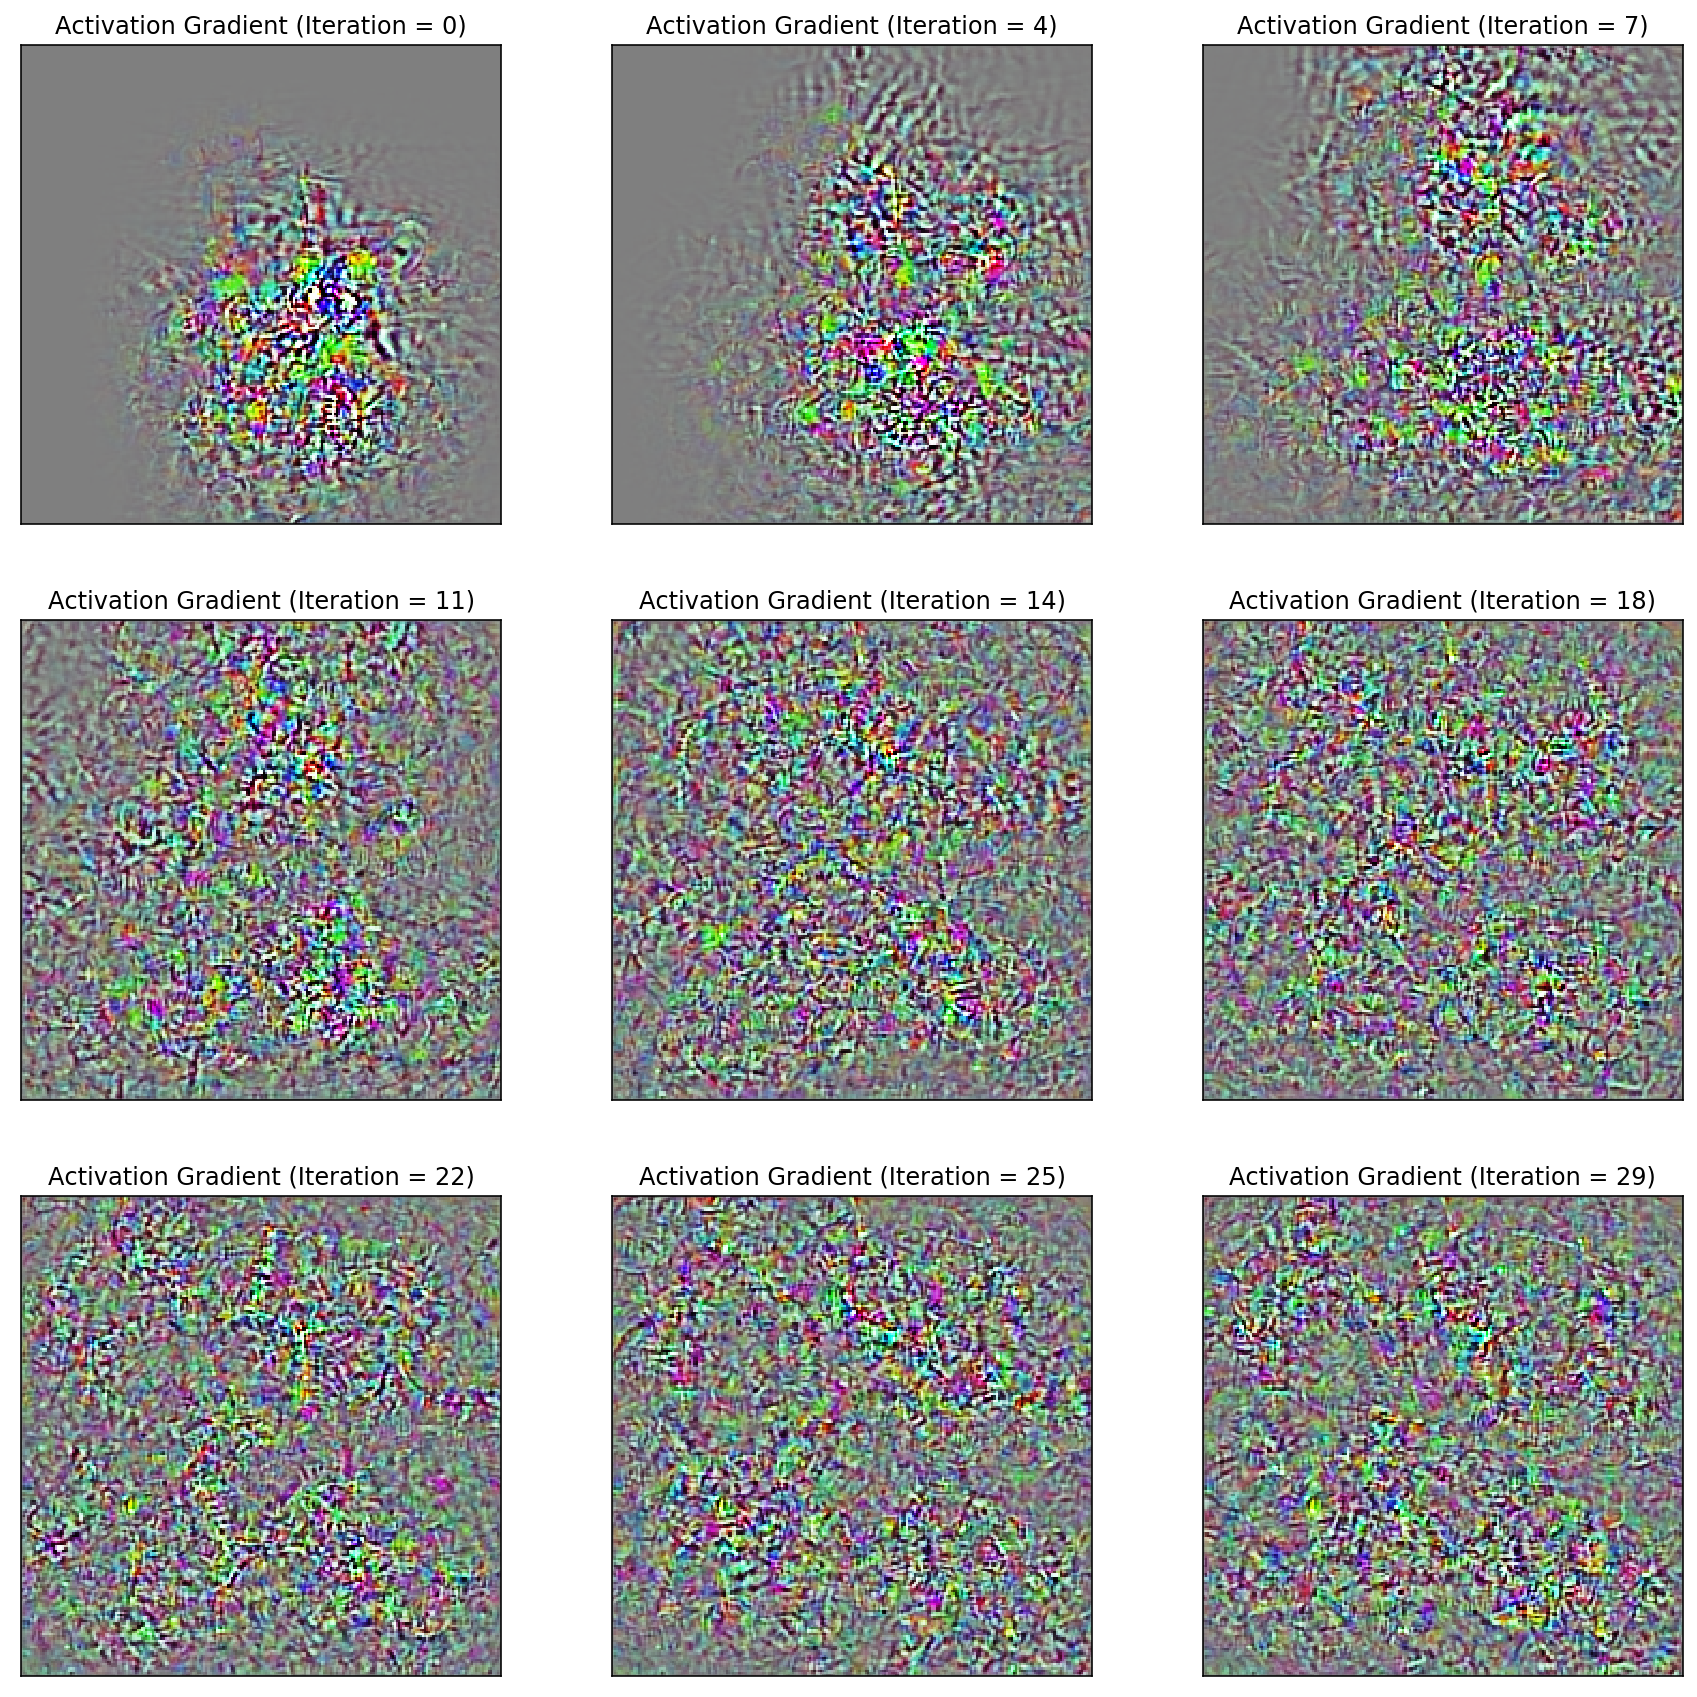

In [21]:
from utils import plot_gradient

nrows = 3
ncols = 3
idxs = np.linspace(0, len(gradients)-1, nrows*ncols)
idxs = idxs.round().astype(int)

plt.figure(figsize=[5 * ncols, 5 * nrows])

for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    grad = gradients[idx][0]
    plot_gradient(grad)
    plt.title(f'Activation Gradient (Iteration = {idx})')

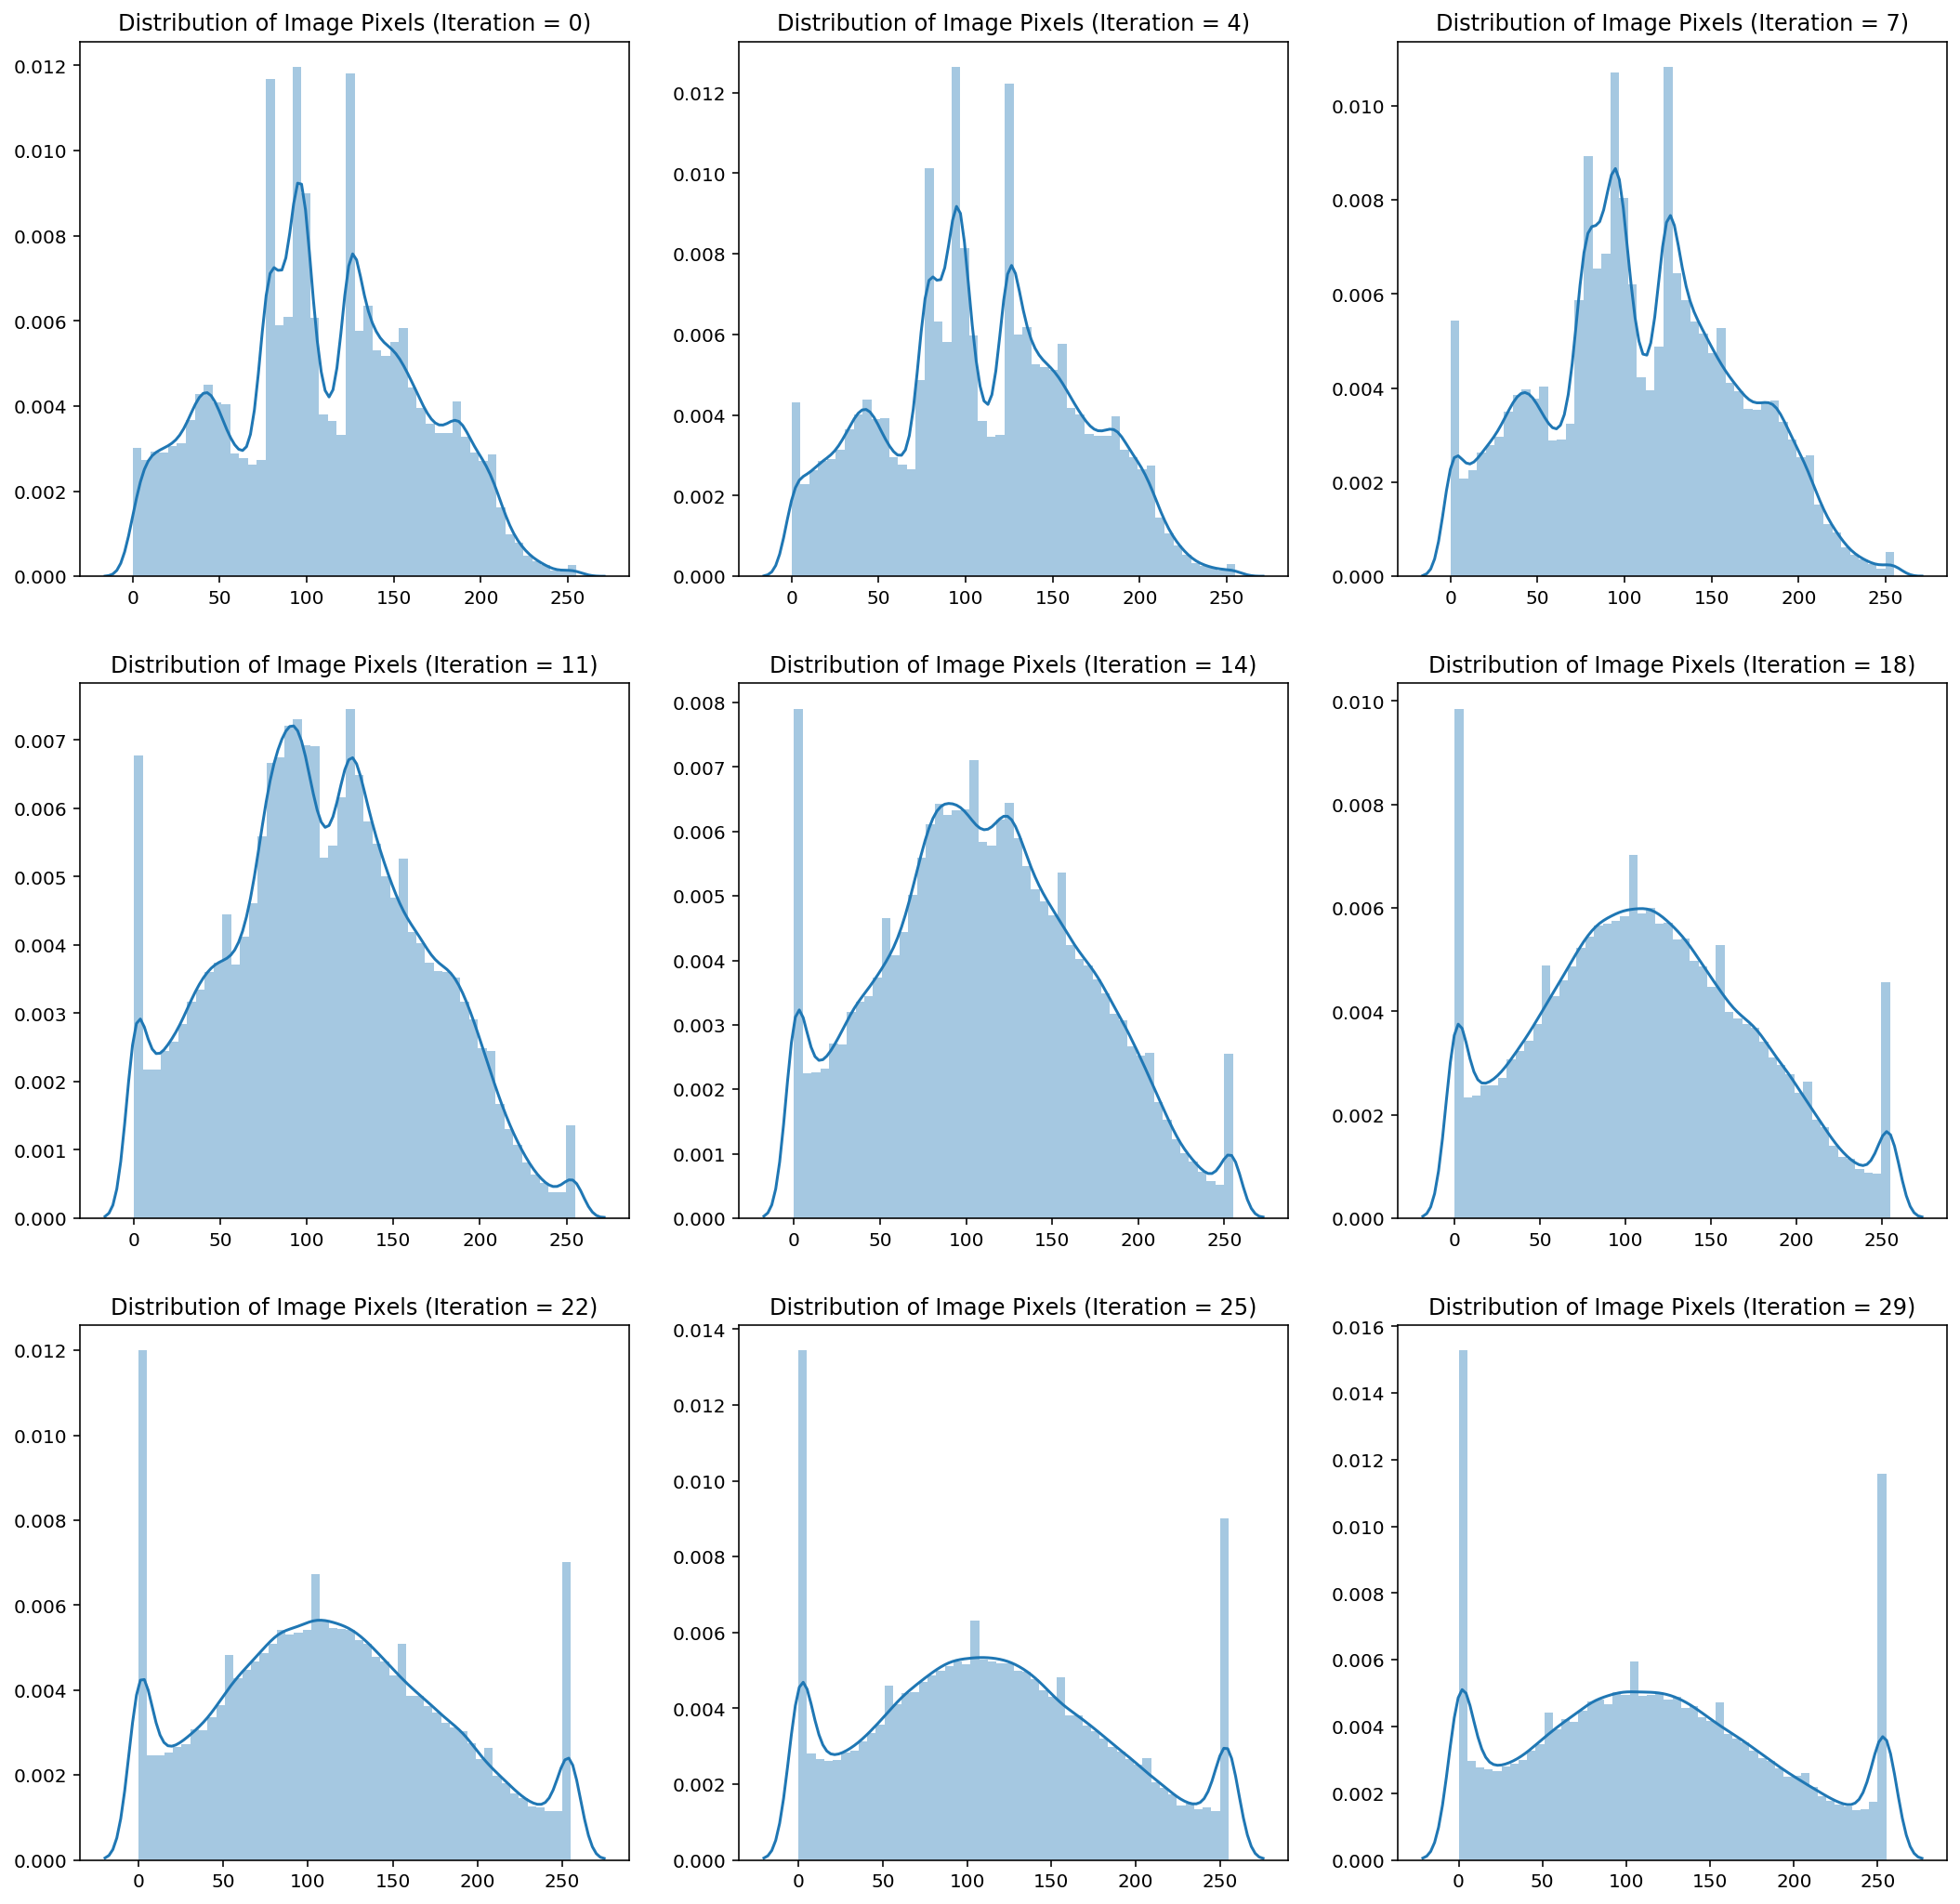

In [22]:
import seaborn as sns
import math

nrows = 3
ncols = 3
idxs = np.linspace(0, len(images)-1, nrows*ncols)
idxs = idxs.round().astype(int)

plt.figure(figsize=[6*ncols, 6*nrows])

for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'Distribution of Image Pixels (Iteration = {idx})')
    sns.distplot(images[idx].reshape(-1))

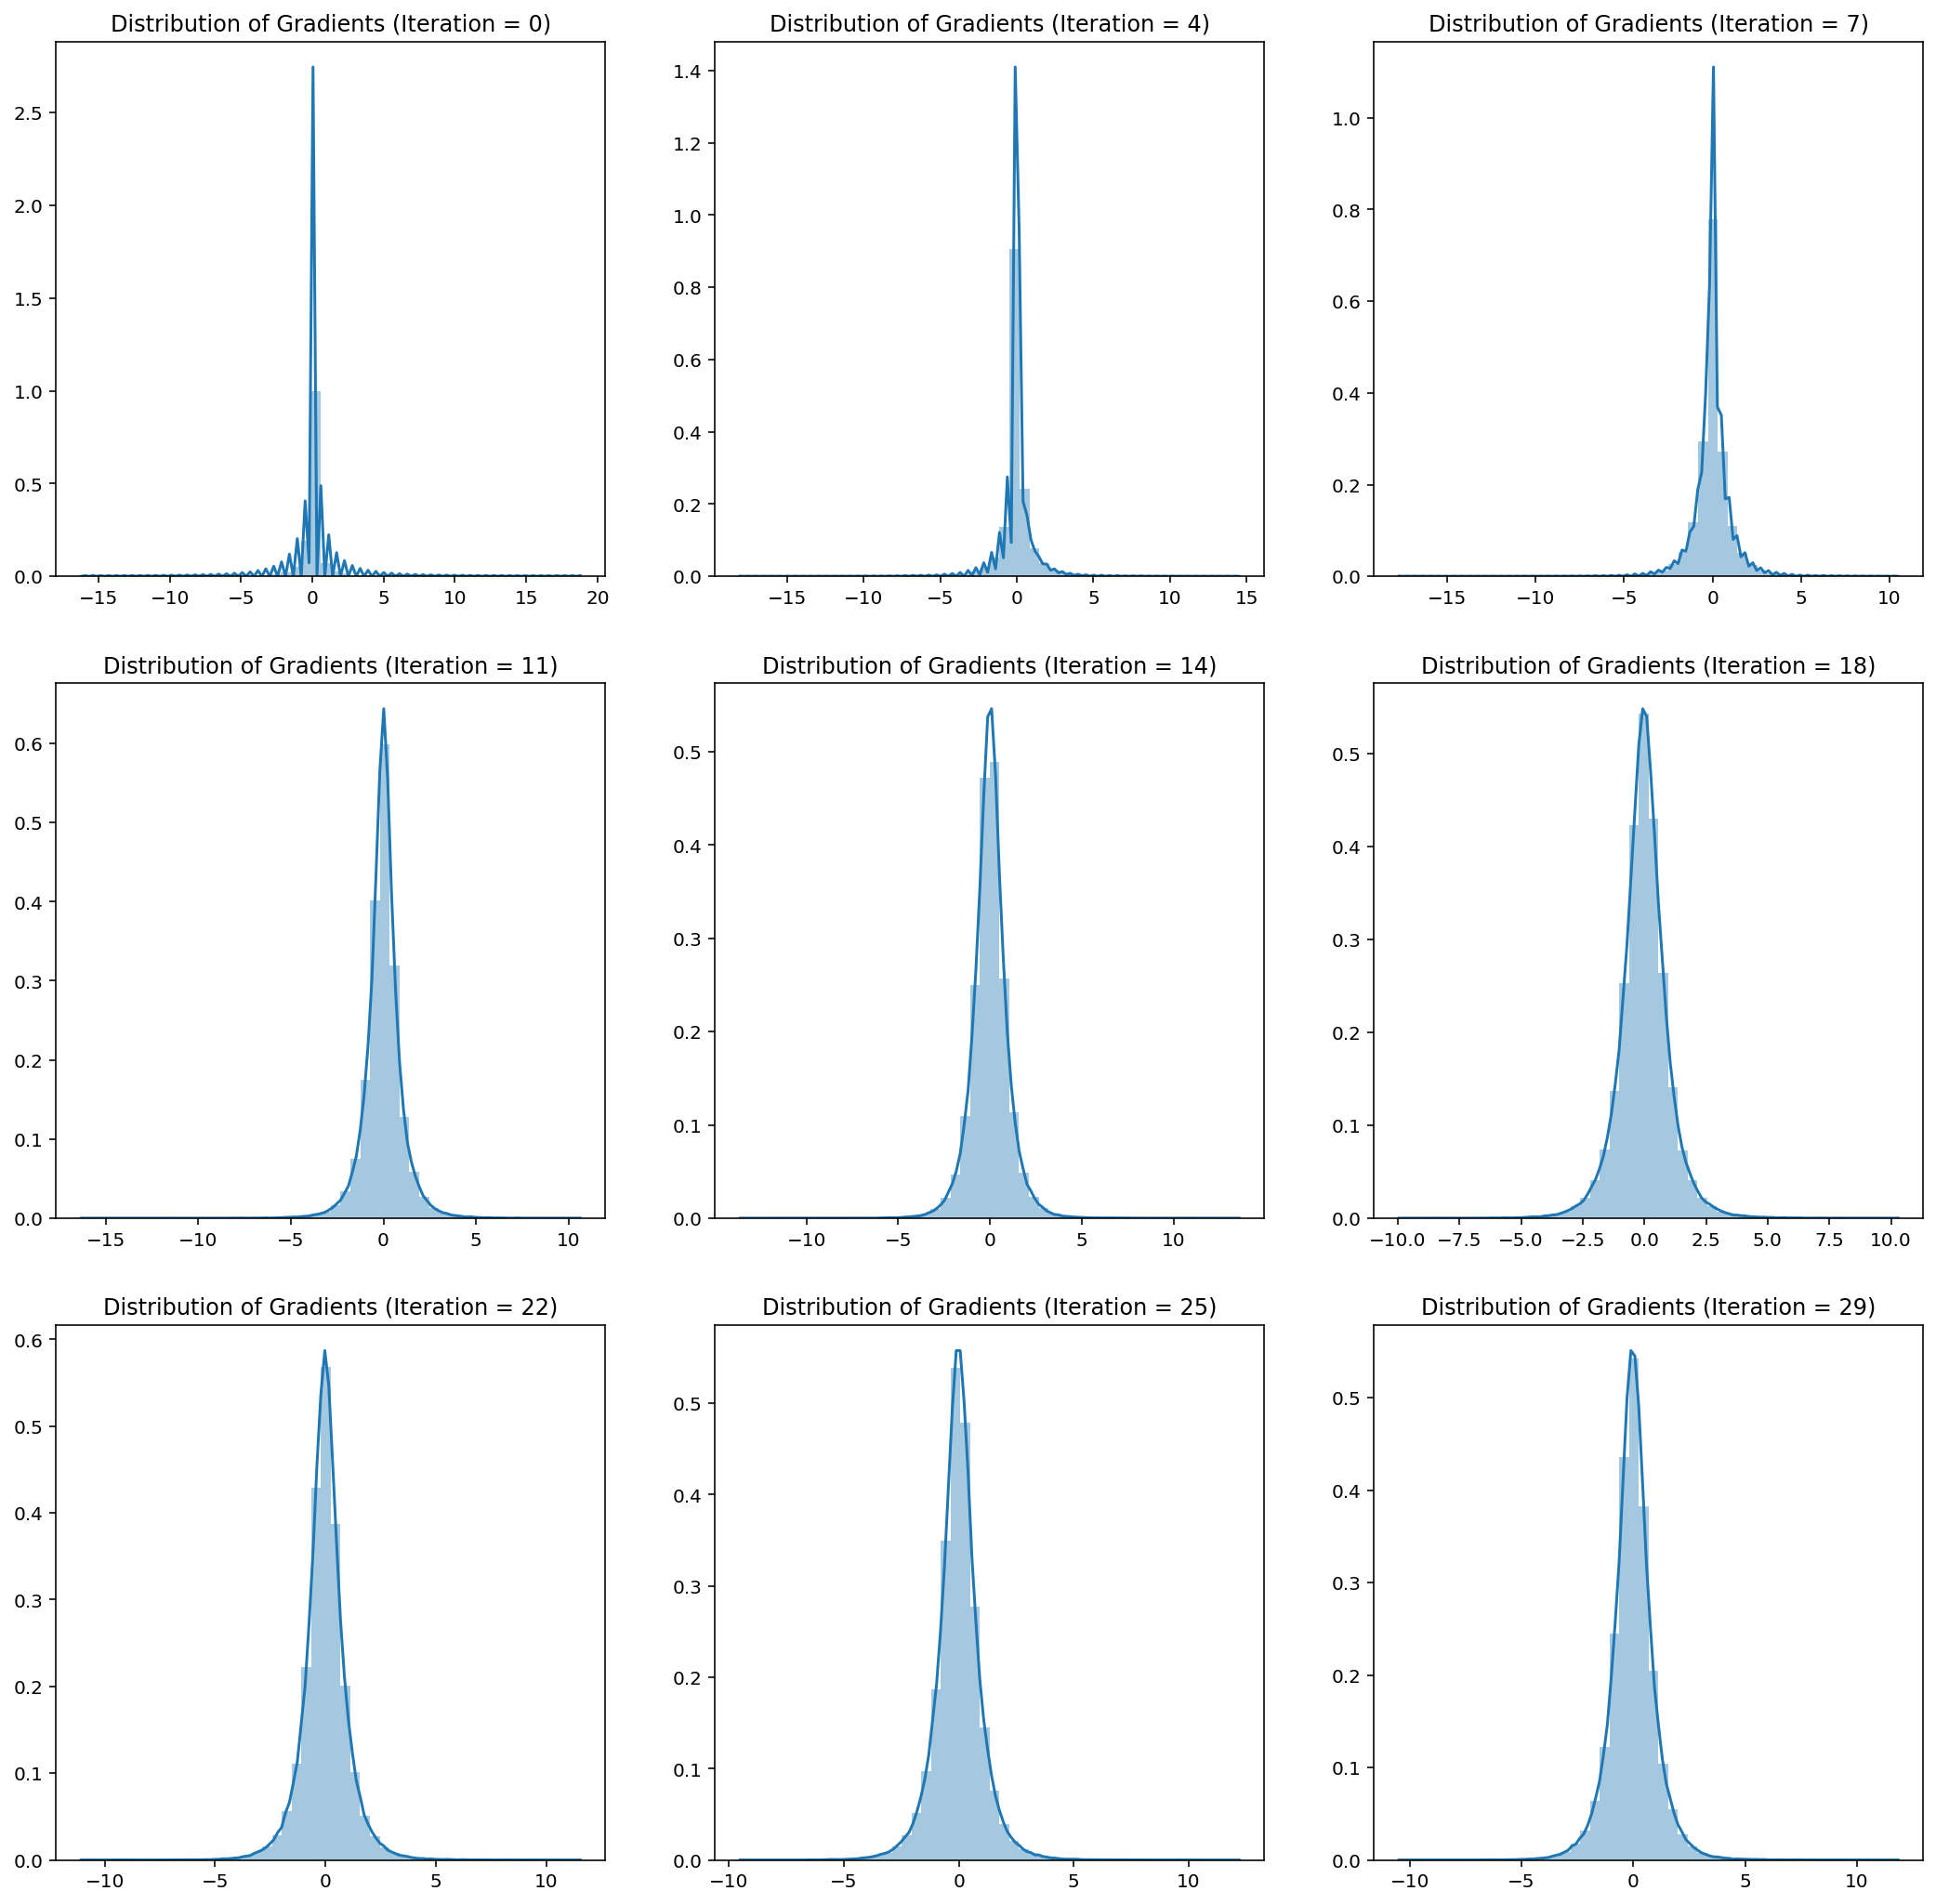

In [23]:
import seaborn as sns
import math

nrows = 3
ncols = 3
idxs = np.linspace(0, len(gradients)-1, ncols*nrows)
idxs = idxs.round().astype(int)

plt.figure(figsize=[6*ncols, 6*nrows])

for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'Distribution of Gradients (Iteration = {idx})')
    sns.distplot(gradients[idx].reshape(-1))